# (refactored) Sweep1D

The LabVIEW-Python workflow is peculiar as objects can be initialized and passed around between functions, however, ONLY FUNCTIONS can be called from within LabVIEW. For abstraction we initialize an keithleys and experiment (which under the hood have their own classes and special types) allowing us to manipulate them independently of the sweep function. Also, eventually this should allow us to replace the keithely object with a general source measurement object in case we want to use other units.

Within the LabVIEW graph (I assume) we will be able to instantiate and control each unit independently of sweeps.

In [1]:
def _do_imports():
    """Imports necessary modules to perform a 1D sweep.

    This method checks if the modules are already imported; if not, it imports them.
    """
    global VisaIOError, Measurement, initialise_database, new_experiment, plot_dataset, Keithley2450

    try:
        import pyvisa
        from pyvisa import VisaIOError
    except ImportError:
        raise ImportError("pyvisa module is required but not installed.")
    
    try:
        from qcodes.dataset import (
            Measurement,
            initialise_database,
            new_experiment,
            plot_dataset,
            initialise_or_create_database_at,
        )
    except ImportError:
        raise ImportError("qcodes.dataset module is required but not installed.")
    
    try:
        from qcodes.instrument_drivers.Keithley import Keithley2450
    except ImportError:
        raise ImportError("qcodes.instrument_drivers.Keithley module is required but not installed.")

In [2]:
def initialize_keithley(device_name: str, address: str, four_wire_mode: bool=False):
    """Initialize a keithley 2450 source measurement device.

    We may consider extending this in the future to allow initilization with other properties.

    Typical usage example:
        keithley1 = initialize_keithley(device_name="Keithley1", address="USB0::1510::9296::04584899::0::INSTR")
        keithley2 = initialize_keithley(device_name="Keithley2", address="USB0::3029::1123::81123123::0::INSTR", four_wire_mode=True)

    Args:
        device_name (str): Name which will appear in the experiment database
        address (str): Device address as described in the keithley manual. The USB format is:
            USB0::[vendor ID]::[model number]::[serial number]::INSTR
        four_wire_mode (bool, optional):
            
    returns:
        qcodes.instrument_drivers.Keithley.Keithley_2450.Keithley2450

    """
    _do_imports()
    keithley = Keithley2450(device_name, address)
    keithley.reset()
    keithley.sense.four_wire_measurement(four_wire_mode)
    return keithley

In [3]:
def initialize_experiment(database_name: str, sample_name: str="no sample"):
    """Initialize an experiment (database and collection of runs)
    
    We need to add support for setting a unique path. Currently writes the database to the home path.

    Typical usage example:
        exp = initialize_experiment("Demo_Experiment")

    Args:
        database_name (str): Name of the database file on disk.
        sample_name (str, optional): Sample name which will appear in the experiment database. 

    Returns:
        qcodes.dataset.experiment_container.Experiment

    """
    _do_imports()
    initialise_database()
    experiment = new_experiment(name=database_name, sample_name=sample_name)
    return experiment

In [4]:
def Sweep1D(
    keithley,
    experiment,
    start: float,
    stop: float,
    step: float,
    sense: str,
    sense_range: float,
    source: str,
    source_range: float
):
    """RUN a 1D sweep using a keithley 2450. 

    Abstraction to any SMU will be implemented in the future.

    Typical usage example:
        Sweep1D(
            keithley=keithley1, 
            experiment=exp,
            start=0,
            stop=10,
            step=0.1,
            sense="current",
            sense_range=1E-5,
            source="voltage",
            source_range=0.2,
        )

    Args:
        keithey (qcodes.instrument_drivers.Keithley.Keithley_2450.Keithley2450): The keithley device to be operated on. Initialize one with initialize_keithley().
        experiment (qcodes.dataset.experiment_container.Experiment): The experiment to save to. Initialize one with initialize_experiment().
        start (float): startpoint for the sweep.
        stop (float): endpoint for the sweep.
        step (float): step size for the sweep.
        sense (str): parameter to be read from the SMU.
        sense_range (float):
        source (str): parameter to be written to the SMU.
        source_range (float):

    Returns:
        NoneType

    """
    _do_imports()
    # Configure the instrument
    keithley.sense.function(sense)
    keithley.sense.range(sense_range)
    
    keithley.source.function(source)
    keithley.source.range(source_range)
    keithley.source.sweep_setup(start, step, stop)
    
    # Perform the measurement
    meas = Measurement(exp=experiment)
    meas.register_parameter(keithley.sense.sweep)

    with meas.run() as datasaver:
        datasaver.add_result((keithley.source.sweep_axis, keithley.source.sweep_axis()),
                             (keithley.sense.sweep, keithley.sense.sweep()))

        dataid = datasaver.run_id

    # Plot the dataset
    plot_dataset(datasaver.dataset)
    keithley.reset()

In [5]:
exp = initialize_experiment("Keithley_2450_example")

There is (are) already experiment(s) with the name of Keithley_2450_example and sample name of no sample in the database.


In [6]:
keithley1 = initialize_keithley("Keithley1", "USB0::1510::9296::04584899::0::INSTR")

Connected to: KEITHLEY INSTRUMENTS 2450 (serial:04584899, firmware:1.7.12b) in 0.36s


Starting experimental run with id: 4. 


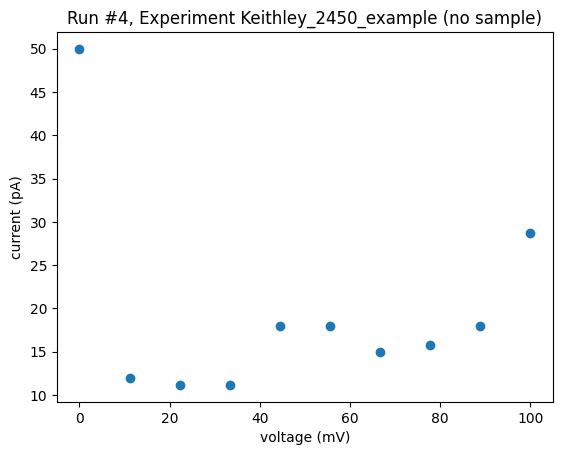

In [7]:
Sweep1D(
    keithley=keithley1, 
    experiment=exp,
    start=0,
    stop=10,
    step=0.1,
    sense="current",
    sense_range=1E-5,
    source="voltage",
    source_range=0.2,
)